In [1]:
import scipy.stats as st
import scipy
from statsmodels.stats.weightstats import ztest, ttest_ind
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import requests
import sys
import inspect

# Libs

### jinja

In [ ]:
http://zetcode.com/python/jinja/#:~:text=Jinja%20simple%20example,create%20a%20very%20simple%20template.&text=The%20example%20asks%20for%20a,and%20have%20many%20more%20features.
from jinja2 import Template
msg = """hello {{ x }}"""
tmpl = Template(msg)
tmpl.render(x=5)

# пример рендеринг-синтаксиса
msg = """
SELECT
{% for i in i_list %}
{% if i < 3 %}
    {{ i }},
{% endif %}
{% endfor %}
    {{ k }}
FROM smth
"""
tmpl = Template(msg)
print(tmpl.render(k=5, i_list=[1,2,3]))

### yaml

In [1]:
import yaml

In [33]:
config_file = './HH/hh_github/hh-airflow/tasks/statistic-puller/ab/employer/employer_cart_purchases_n_days.yaml'
with open(config_file, 'r', encoding='utf8') as f:
    config = yaml.safe_load(f)

In [45]:
config

{'driver': 'presto',
 'params': [{'table': 'ab.employer_cart_purchases_7_days', 'interval': 7},
  {'table': 'ab.employer_cart_purchases_14_days', 'interval': 14}],
 'insert_sql': 'ab/employer/employer_cart_purchases_n_days.sql',
 'dependencies': ['ab.employer_authorized_with_country',
  'billing.account',
  'billing.cart',
  'billing.service',
  'billing.services_cart',
  'billing.employer_service',
  'billing.account_service_package_entry',
  'billing.bargain_element']}

In [37]:
params = config['params'][0]

In [38]:
tuple(set(config.get('dependencies', [])) | set(config['params'][0].get('dependencies', [])))

('billing.bargain_element',
 'billing.account',
 'billing.service',
 'billing.account_service_package_entry',
 'billing.services_cart',
 'billing.employer_service',
 'ab.employer_authorized_with_country',
 'billing.cart')

In [41]:
config.get('name', params.get('task_name', params['table']))

'ab.employer_cart_purchases_7_days'

In [44]:
params.get('notify', '#airflow-alerts')

'#airflow-alerts'

### requests

In [23]:
import requests
# GET и передача query-параметров
# r=requests.get('https://yandex.ru/search/?lr=213&text=good')
r=requests.get('https://yandex.ru/search/', params={'lr' : 213, 'text' : 'good'})
'good' in r.text

True

In [116]:
r=requests.get('https://ya.ru') # получили ответ от сервера
print(r.encoding) # какая сейчас кодировка для дешифровки строки. Можно менять в процессе
print(r.content[1500:1510]) # raw формат битовой строки ответа
print(r.text[1500:1510]) # ответ с автоматической декодировкой 

UTF-8
b'\x80\xd1\x82 \xd0\xb8 \xd1\x82\xd0'
анилище. Н


In [117]:
# заголовок запрос с мета-информацией
dict(r.headers).keys()

dict_keys(['Accept-CH', 'Accept-CH-Lifetime', 'Cache-Control', 'Content-Encoding', 'Content-Security-Policy', 'Content-Type', 'Date', 'Expires', 'Last-Modified', 'P3P', 'Set-Cookie', 'Transfer-Encoding', 'X-Content-Type-Options', 'X-Frame-Options', 'X-Yandex-Sdch-Disable'])

In [118]:
"""
АУТЕНТИФИКАЦИЯ - способ опознать конкретного клиента
Cookie запроса - небольшой фрагмент отправляемый сервером клиенту при взаимодействии
при последующем обращении браузера на сервис с отправкой куков можно атентифицировать пользователя и пр.
могут использоваться для персонализации, доступов, таргетирования 
если браузер поддерживает куки и дал согласие, то куки из заголовка устанавливаются
у куков есть проблема безопасности - возможна их кража/подмена при общении по незащищенному каналу

Альтернатива:
слежение через URL - на странице отправляемой сервером размещается ссылка с get-запросом с
уникальными query-параметрами. Однако эта информация неизменна и может шариться, если
пользователь передает конкретную ссылку

базовая аутентификация - сервер запрашивает логин-пароль, браузер при вводе данных это запоминает
и дальше использует при доступе к страницам веб-сайта
"""

print(r.cookies.keys())
print(r.cookies['i']) # одна из кук
print(r.headers['Set-Cookie']) # указание от сервера об установке куков

['i', 'is_gdpr', 'is_gdpr_b', 'mda', 'yandex_gid', 'yandexuid', 'yp']
02G60xVWxs5qtBc7x22YY9qxT8mnPurWQJGwfupyPKRlmiNTbqFgRwZsWhIyLG8+3QKySJRYqr7pSkc14s3HmyYGZU0=
yp=1604263976.ygu.1; Expires=Mon, 30-Sep-2030 20:52:56 GMT; Domain=.ya.ru; Path=/, mda=0; Expires=Sat, 30-Jan-2021 20:52:56 GMT; Domain=.ya.ru; Path=/, yandex_gid=213; Expires=Sun, 01-Nov-2020 20:52:56 GMT; Domain=.ya.ru; Path=/, yandexuid=4975419011601671976; Expires=Mon, 30-Sep-2030 20:52:56 GMT; Domain=.ya.ru; Path=/, is_gdpr=0; Path=/; Domain=.ya.ru; Expires=Sun, 02 Oct 2022 20:52:56 GMT, is_gdpr_b=CNnvZBC/BCgC; Path=/; Domain=.ya.ru; Expires=Sun, 02 Oct 2022 20:52:56 GMT, i=02G60xVWxs5qtBc7x22YY9qxT8mnPurWQJGwfupyPKRlmiNTbqFgRwZsWhIyLG8+3QKySJRYqr7pSkc14s3HmyYGZU0=; Expires=Sun, 02-Oct-2022 20:52:56 GMT; Domain=.ya.ru; Path=/; Secure; HttpOnly


In [126]:
# сами отправляем куки при запросе
r2=requests.get('https://ya.ru', cookies={'cookie_name' : 'test'})

In [132]:
r = requests.get('https://api.github.com/users/user', auth=('1', '2'))
# в случае ошибки запроса - мы можем подробнее исследовать причину
r.raise_for_status()

HTTPError: 401 Client Error: Unauthorized for url: https://api.github.com/users/user

In [135]:
# возможность трекать редиректы
r=requests.get('https://google.com')
r.history  # 301 - статус - редирект

[<Response [301]>]

In [5]:
import getpass
login = getpass.getpass()
password = getpass.getpass()

········
········


In [6]:
# session - объект, позволяющий сохранять настройки коммуникации с сервером (persistense)
# r = requests.get('https://api.github.com/users/user', auth=(login, password))
session = requests.Session()
session.auth=(login, password) # и все остальные параметры вроде headers, params ... 
response=session.get('https://api.github.com/users/gavrevnik')

In [ ]:
# можно изготавливать динамический пайплайн из методов, ссылок и параметров
# для того чтобы взаимодействовать с сервером
# см Requests, Session, session.prepare_request(Requests)

In [1]:
"""
АВТОРИЗАЦИЯ - способ передачи клиенту прав доступа на ресурсы сервера

HTTPBasicAuth. По умолчанию auth=(log, pass) - базовая авторизация
После того, как пользователь вводит пароль - браузер его запоминает и использует самостоятельно
По апи креденты передаются прямо в теле http-запроса (не очень секьюрно)

HTTPDigestAuth - md5 шифрование пароля базовой аутентификации

OAuth - token-based auth
Authorization: Bearer 
Протокол позволяет предоставить третьей стороне ограниченный доступ 
к защищённым ресурсам пользователя без необходимости передавать ей (третьей стороне) логин и пароль
Схема: идем с login,password к серверу. Сервер отправляет обратный запрос со своим идентификатором
Подтверждаем что хотим получить права, проверяя адрес сервера
Сервер выдает токен на конечное время, который везде используем в запросах
"""
from requests.auth import HTTPBasicAuth
r_ = requests.get('https://api.github.com/users/gavrevnik', auth=HTTPBasicAuth(login, password))

NameError: name 'requests' is not defined

In [34]:
# установили свой локальный сервер и запустили его
data = json.dumps({'a' : 1})
r=requests.post('http://localhost:1234/hello', json=data)
r.text

'1'

In [26]:
json.dumps("""{'a' : 1}""")

'"{\'a\' : 1}"'

### Re

In [ ]:
import re
re.findall('\w+', text)

### ENCODINGS

In [ ]:
# chardet, codec
# вопросы и проблемы кодировок

# Language

### multi proc/thread

In [2]:
import concurrency

In [3]:
concurrency.thread_ex2()

[1] => 1
[3] => 2
[3] => 3
[3] => 4
[3] => 5
[1] => 6
[1] => 7
[1] => 8
[1] => 9
[3] => 10
[0] => 11
[0] => 12
[0] => 13
[0] => 14
[0] => 15
[2] => 16
[2] => 17
[2] => 18
[2] => 19
[2] => 20
[4] => 21
[4] => 22
[4] => 23
[4] => 24
[4] => 25
finish


In [4]:
os.getpid() # родительский pid


85180

### Inheritance

In [ ]:
# зачем нам нужен super() ?

In [ ]:
class First(object):
    def __init__(self, x):
        print("first", x)

class Second(object):
    def __init__(self):
        print("second")

class Third(First):
    def __init__(self):
        print('hello')
        print(__class__)
        First.__init__(self, 3)
        

Third()   

### attrs

Методы управления атрибутами вне и внутри инстанса  
getattr(obj, attr_name, default) -> val  
setattr(obj, attr_name, attr_val) -> obj.attr_name = val  
hasattr(obj, attr_name) -> T/F  
delattr(obj, attr_name)  
аналоги внутри - self.__getattr__(...) ...  
Посмотреть список аттрибутов инстанса -> obj.__dict__  

property - возможность создавать внутри class сущность 
attr = property(getx, setx...) с определенными правилами 
обращения/вычисления. cached_property - аналог синглетона

In [75]:
class Parrot:
    def __init__(self):
        self._voltage = 100000
        self.__x = 2
ins = Parrot()

In [76]:
# class property(fget=None, fset=None, fdel=None, doc=None)
# гибкое управление свойствами атрибутов инстанса

In [108]:
class C:
    def __init__(self):
        self._x = None

    def getx(self):
        return self._x

    def setx(self, value):
        print(f'set x = {value}')
        self._x = value

    def delx(self):
        del self._x

    x = property(getx, setx, delx, "I'm the 'x' property.")

In [118]:
ins = C()
ins.x = 3
ins.x

set x = 3


3

In [150]:
class Parrot:
    def __init__(self):
        # скрытый атрибут
        self._voltage = 100000
    @property
    # read-only
    def voltage(self):
        return self._voltage
#     декоратором
#     voltage = property(voltage)

    def voltage_setter(self, value):
        if value > 0:
            self._voltage = value
        else:
            print('value > 0')
    voltage=voltage.setter(voltage_setter)
#     декоратором
#     @voltage.setter
#     def voltage_setter(self, value) ...
    
ins = Parrot()
print(ins.voltage)
ins.voltage = -1
ins.voltage = 10
print(ins.voltage)

100000
value > 0
10


In [151]:
# проверка - есть ли такой атрибут с возможностью его изменения
class Parrot:
    @property
    def voltage(self):
        if 'voltage' not in self.__dict__:
            self.__dict__['voltage'] = 'default'
        return self.__dict__['voltage']
    
    @voltage.setter
    def voltage(self, value):
        self.__dict__['voltage'] = value
    
ins = Parrot()

In [173]:
from cached_property import cached_property
class Test:
    def __init__(self):
        self._x = 1
    
    @property
    def x(self):
        self._x += 1
        return self._x
    
    # фиксирует на момент вычисления величину
    # возвращает ее постоянное значение
    @cached_property
    def cached_x(self):
        self._x += 1
        return self._x
ins = Test()

print(ins.x)
print(ins.x)
print(ins.cached_x)
ins._x = 2
print(ins.x)
print(ins.cached_x)

2
3
4
3
4


### iterators

Итерируемый объект - любой объект для которого iter(obj) возвращает иттератор  
Последовательность - коллекция элементов, для которой возможен вызов __getitem__ позволяющий обращаться  
к элементам коллекции по индексу  
__iter__ Метод возвращающий итератор при применении iter(obj)   
Если iter(obj) не находит __iter__ то может использовать целочисленную проходку по __getitem__  
Поэтому любая последовательность является иттерируемой  

Итератор - объект, имеющий __next__ метод, позволяющий при next(obj) последовательно возвращать  
элементы объекта до StopIteration, а также __iter__ возвращающий себя (для циклов) -> iter(obj) is obj


In [23]:
# range - неявный иттератор с ленивым вычислением
x1 = range(10); print(sys.getsizeof(x1))
x2 = range(100); print(sys.getsizeof(x2))
y1 = list(range(10)); print(sys.getsizeof(y1))
y2 = list(range(100)); print(sys.getsizeof(y2))

48
48
200
1008


In [76]:
# перебор всех слов в строке
text = '1 2 3'
class Seq:
    def __init__(self, text):
        self.text = text
        self.words = text.split(' ')
    def __getitem__(self, index):  # seq[i] -> __getitem__(self, index=i)
        return self.words[index]    
    def __len__(self):
        return len(self.words) # len(seq) -> __len__()
ins = Seq(text)
for j in ins: # иттерируемая последовательность
    print(j)

1
2
3


In [152]:
class Iterator:
    """Возвращает объект итератора"""
    def __init__(self, seq):
        self.seq = seq # объект
        self.index = 0 # для обхода объекта
    
    def __next__(self):
        # next(obj) должен давать следующий элемент
        print('next(obj)')
        try:
            elem = self.seq[self.index]
        except:
            raise StopIteration()
        self.index += 1
        return elem
    
    # возвращаем себя
    def __iter__(self):
        print('iter(obj)')
        return self
# пример итератора, который создает цикл
it = Iterator([1,2,3])
# как цикл обрабатывает итератор (перехватывая исключение в конце)
for j in it:
    print(j)

iter(obj)
next(obj)
1
next(obj)
2
next(obj)
3
next(obj)


In [155]:
text = 'hello world'
class Seq_classic:
    def __init__(self, text):
        self.text = text
        self.words = text.split(' ')
    # цикл первым делом делаем iter
    # и дальше по нему уже next
    def __iter__(self):
        return Iterator(self.words)
    
ins = Seq_classic(text)
for j in ins:
    print(j)

next(obj)
hello
next(obj)
world
next(obj)


In [64]:
# применение iter с 2-мя аргументами
def seq():
    return np.random.choice([1,2,3,4,5])
seq_while_3 = iter(seq, 3)
for s in seq_while_3:
    print(s)

2
5
2


### generators

Генераторная функция - функция, в которой определено слово yield  
Обычная функция возвращает значения, генераторная функция возвращает генератор  
Генератор порождает значения при итерировании по нему  
Можно задавать генератор генераторным выражением - (j for j in seq)   
Вместо for j in seq: yield j  
Ленивое вычисление с генератором экономит память и вычислительную мощность,  
так как вычисляются только требуемые выражения "на лету"  

In [176]:
# более простой пример реализации из раздела iter
class Seq:
    def __init__(self, text):
        self.text = text
        self.words = text.split(' ')
    # генераторная функция
    # перебор параметров и исключение под капотом
    def __iter__(self):
        for word in self.words:
            yield word
ins = Seq('hello world')
for j in ins:
    print(j)

hello
world


In [72]:
# арифметическая прогрессия
def ar_prog(x0, d, N):
    for j in range(N):
        yield x0 + d * j
ar=ar_prog(0, 0.5, 3)
for j in ar:
    print(j)

0.0
0.5
1.0


In [118]:
# функция Фибоначи
def get_fib():
    a, b = 0, 1
    while True:
        yield a
        a, b = b, b + a
fib = get_fib()
c = 0
for j in fib:
    c+=1
    print(j)
    if c > 5:
        break

0
1
1
2
3
5


In [38]:
# библиотека готовых генераторных функций
import itertools
it = [1,2,3,4,5]
def filt(x):
    return x > 3
gen = filter(lambda x: x > 3, it) # [4, 5]
gen = map(lambda x: x**2, it) # [1, 4, 9, 16, 25]
gen = itertools.accumulate(it, min) # cumsum/min/max/...
gen = itertools.permutations(it) # перестановки всех элементов

In [46]:
it1, it2 = ['a', 'b', 'c'], [1, 2, 3]
gen1, gen2 = zip(it1, it2), map(lambda a,b: (a,b), it1, it2)
list(gen1) == list(gen2)

True

Сопрограммы  
Каждый next(gen) вызов генератора итерирует его код до следующего yield и выдает значение
gen.send() позволяет передавать данные генератору извне - генератор становится сопрограммой. 
yield from - конструкция которая позволяет связать вывод генератора с окружающей средой, превратив ее в генератор тоже
yield - ключевое слово управления потоком данных - иногда оно лениво отдает информацию, иногда - принимает  


In [100]:
def genf():
    def get_sq(x):
        yield x**2
    for j in range(10):
        yield from get_sq(j) # тунелирование генератора вовне
#         yield get_sq(j) # genf - функция выводящая генераторы
list(genf())

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [254]:
# сопрограмма принимает параметр и далее отдает его
def avg():
    total = 0
    n = 0
    average = None
    while True:
        new_val = yield average # avg.send(average)
        total += new_val
        n += 1
        average = total / n # avg.yield -> average

avg = avg()
next(avg) # init - до ближайшего yield
print(avg.send(4))
print(avg.send(10))

In [296]:
# сопрограмма принимает параметр и далее отдает его
def avg():
    x = 'init'
    while True:
        print('pre_step')
        ad = yield x # в x здесь ничего не записывается!
        print('from x = ', ad)
        x = 'step'
        yield x

avg = avg()
next(avg) # init - до ближайшего yield

pre_step


'init'

In [297]:
avg.send('input')

from x =  input


'step'

In [ ]:
inspect.ge

In [298]:
avg.send('input2')

pre_step


'step'

In [291]:
avg.send('input3')

from x =  input3


'step'

### abstract Class

Интерфейсы - наборы открытых методов класса, позволяющие его использовать по введенным соглашениям  
Пример - протокол последовательности. Если класс имеет минимальные черты этого протокола - интерпретатор обрабатывает
его, как последовательность. 

Абстрактный класс - это класс, в котором прописана структура, которую необходимо должны соблюдать его потомки
При этом сам класс не имеет прямых инстансов. Это инструкция для наследующих:  
"чтобы меня вызвать надо определить то-то и то-то" При этом свойства могут быть описаны в документации  
Также в абстрактном классе могут быть реальные методы 

Определение абстрактного базового класса позволяет зафиксировать API для семейства потомков

In [423]:
import abc
# Абстрактный класс с определенными требованиями к потомкам
class Movable(abc.ABC):
    @abc.abstractmethod
    def move():
        """Переместить объект"""
        
    @staticmethod
    @abc.abstractmethod
    def speed():
        """Скорость объекта"""
    
class Car(Movable):
    def __init__(self, car_name):
        self.car_name = car_name
    
ins = Car('car_1')

TypeError: Can't instantiate abstract class Car with abstract methods move, speed

In [428]:
class Car_fix(Car):
    def __init__(self, name):
        self.name = name
    def move(self):
        print('move')
    @staticmethod
    def speed():
        print('read_only speed')
    
ins=Car_fix(2) 
ins.speed()

read_only speed


In [429]:
# Пример использования готового абстрактного класса
from collections import abc
class Sq(abc.Sequence):
    def __init__(self):
        pass
ins = Sq()

TypeError: Can't instantiate abstract class Sq with abstract methods __getitem__, __len__

#  OTHER

### reserach?

In [2]:
x = st.uniform.rvs(size=10000000)
y = st.uniform.rvs(size=10000000)

0.5000543791750123

In [224]:
4 * len([j for j in tuple(zip(x, y)) if (j[0]**2 + j[1]**2 < 1)]) / len(x)

3.1417668

In [215]:
x_ = [j[0] for j in tuple(zip(x, y)) if (j[0]**2 + j[1]**2 < 1)]
y_ = [j[1] for j in tuple(zip(x, y)) if (j[0]**2 + j[1]**2 < 1)]

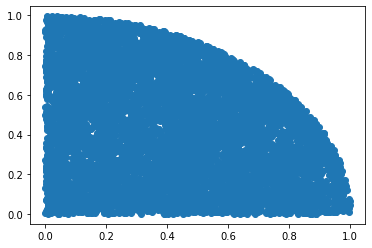

In [217]:
plt.scatter(x=x_, y=y_)

In [ ]:
# abstract class


In [ ]:
contextlib

In [99]:
st.chi2(df=0.1)

AttributeError: 'rv_frozen' object has no attribute 'loc'

In [111]:
x = st.chi2.rvs(size=100000, df=0.1)

In [112]:
np.mean(x)

0.09975105720948595

In [66]:
np.std(x)

5.100356100637719

In [67]:
np.mean(x)

0.06420575720753738

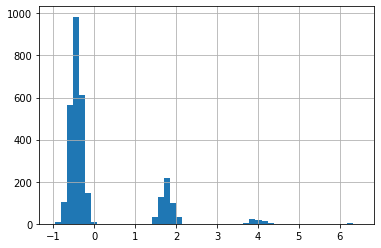

In [82]:
# Иллюстрация ЦПТ
# go
# x = [1,2,3,4,5,6]
# x = list(range(100)) + [10000]
x = np.array(list(st.norm.rvs(size=10000)) + list(st.norm.rvs(size=2, loc=500)))
# x = st.expon.rvs(size=10000)


q = []
N = 1000
for j in range(3000):
    # сумма одинаково распределенных случайных величин 
    sv =  np.random.choice(x, N, replace=True)
#     z = sum(sv)
    z = (sum(sv) - N * np.mean(x)) / (np.std(x) * np.sqrt(N))
    q.append(z)
pd.DataFrame({'q' : q}).q.hist(bins=50)

In [39]:
np.mean(q)

0.01461936786743201

In [40]:
np.std(q)

1.0231815223528247

In [41]:
from scipy.stats import mannwhitneyu, sem, t, kstest, ks_2samp, chi2_contingency, chisquare


In [42]:
kstest(q, 'norm')

KstestResult(statistic=0.03430621458908134, pvalue=0.1855464315155756)

### Visual

In [26]:
def init_matplot(figsize_xy=(10,5), subplot_grid=None):
    """Преднастройка отображения графиков в plt"""
    import matplotlib
    matplotlib.rcParams['figure.figsize'] = figsize_xy
    matplotlib.rcParams['figure.titlesize'] = 20
    matplotlib.rcParams['font.size'] = 20
    matplotlib.rcParams['legend.fontsize'] = 20
    matplotlib.rcParams['axes.titlesize'] = 22
    matplotlib.rcParams['axes.labelsize'] = 20
    matplotlib.rcParams['xtick.labelsize'] = 15
    matplotlib.rcParams['ytick.labelsize'] = 15
    matplotlib.rcParams['lines.linewidth'] = 4
    
    # сетка графиков - на выходе fig, list_ax[n,m]
    # управление через plt.sca(ax)
    if subplot_grid:
        m, n = subplot_grid
        return plt.subplots(m, n)

In [27]:
def visualise_dynamic_df(df=None, figsize_xy=(10, 5)):
    """Визуализируем динамические параметры при накоплении выборки эксперимента
    df -> days_at_exp_start, p_value, std_exp, std_control, mde_list
    """
    if df is None:
        df = pd.DataFrame({'p_value' : [1,2,3]})
    days_list = df.days_at_exp_start.tolist()
    # графики для прорисовки
    subplot_grid = (1, 3)
    fig, list_ax = init_matplot(figsize_xy, subplot_grid)
    plt.sca(list_ax[0])
    p_value_list = df.p_value.tolist()
    plt.plot(days_list, p_value_list)
    plt.title('Динамика p_value для А/Б выборок в \n зависимости от дня эксперимента')
    plt.axhline(y=self._alpha, xmin=min(days_list), xmax=max(days_list),  color='r', linestyle='--')
    plt.xlabel('Дней с начала эксперимента'); plt.ylabel('p_value'); plt.grid()

### class_methods

In [ ]:
class car_creator:
    __car_hist = []
    car_n = 0
    
    @classmethod   
    def _car_num(cls, car_name):
        cls.car_n +=1
        cls.__car_hist.append({cls.car_n : car_name})
        return cls.car_n
    
    def __init__(self, car_name):
        self.car_name = car_name
        car_n = self._car_num(car_name)
        self.car_n = car_n
#         self.car_hist = None

In [ ]:
car1=car_creator('audi')
car2=car_creator('bmw')
car3=car_creator('volvo')